# 04_evaluation_visualization.ipynb

In [1]:
# Model Evaluation and Visualization
import os
import json
import torch
import torch.nn as nn
from torchvision import models, transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import random
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask

In [ ]:
# Paths
DATASET_DIR = "../data/raw/EuroSAT_RGB"
OUTPUT_DIR = "../data/processed"
MODEL_DIR = "../models"
MODEL_PTH = "resnet18_frozen.pth" # Update model file path being evaluated

In [3]:
# Load class mappings
with open(os.path.join(OUTPUT_DIR, "class_mappings.json"), "r") as f:
    mappings = json.load(f)
    class_to_idx = mappings["class_to_idx"]
    idx_to_class = {int(k): v for k, v in mappings["idx_to_class"].items()}

In [ ]:
# Load the model
model_path = os.path.join(MODEL_DIR, MODEL_PTH)
checkpoint = torch.load(model_path, map_location=torch.device('cpu'))

model_name = checkpoint['model_name']
freeze_backbone = checkpoint['freeze_backbone']

In [ ]:
# Create the same model architecture
if model_name == 'resnet18':
    model = models.resnet18(weights=None)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, len(class_to_idx))
elif model_name == 'resnet50':
    model = models.resnet50(weights=None)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, len(class_to_idx))
elif model_name == 'efficientnet_b0':
    model = models.efficientnet_b0(weights=None)
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_ftrs, len(class_to_idx))
elif model_name == 'efficientnet_b4':
    model = models.efficientnet_b4(weights=None)
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_ftrs, len(class_to_idx))

In [6]:
# Load model weights
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# Define transformations for inference
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # ImageNet stats
])

In [8]:
# Function to predict a single image
def predict_image(image_path, model, transform):
    """
    Make a prediction on a single image
    
    Args:
        image_path: Path to the image file
        model: PyTorch model for inference
        transform: Preprocessing transformations
        
    Returns:
        predicted_class: Class index with highest probability
        probabilities: List of probabilities for all classes
        image: Original PIL image
    """
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0)
    
    with torch.no_grad():  # No need to track gradients for inference
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs, 1)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)[0]
    
    return predicted.item(), probabilities.tolist(), image

In [9]:
# Function to visualize prediction with probabilities
def visualize_prediction(image_path, model, transform):
    """
    Visualize an image with its prediction and class probabilities
    
    Args:
        image_path: Path to the image file
        model: PyTorch model for inference
        transform: Preprocessing transformations
        
    Returns:
        class_name: Predicted class name
        top5_prob: Top 5 probability values
        top5_labels: Top 5 class labels
    """
    predicted_class, probabilities, image = predict_image(image_path, model, transform)
    
    # Get class name
    class_name = idx_to_class[predicted_class]
    
    # Get top 5 probabilities
    top5_prob, top5_classes = torch.topk(torch.tensor(probabilities), 5)
    
    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Show image
    ax1.imshow(image)
    ax1.set_title(f"Predicted: {class_name}")
    ax1.axis('off')
    
    # Show probabilities
    top5_labels = [idx_to_class[i.item()] for i in top5_classes]
    colors = ['green' if i == predicted_class else 'grey' for i in top5_classes]
    
    ax2.barh(range(5), top5_prob, color=colors)
    ax2.set_yticks(range(5))
    ax2.set_yticklabels(top5_labels)
    ax2.set_xlabel('Probability')
    ax2.set_title('Top 5 Predictions')
    
    plt.tight_layout()
    plt.show()
    
    return class_name, top5_prob.tolist(), top5_labels

In [10]:
# Function to get random images from the dataset
def get_random_images(num_images=5):
    """
    Get random image paths from the dataset
    
    Args:
        num_images: Number of random images to select
        
    Returns:
        images: List of image file paths
    """
    images = []
    class_dirs = sorted(os.listdir(DATASET_DIR))
    
    for _ in range(num_images):
        # Select random class
        class_name = random.choice(class_dirs)
        class_path = os.path.join(DATASET_DIR, class_name)
        
        # Select random image from class
        image_file = random.choice([f for f in os.listdir(class_path) if f.endswith('.jpg')])
        image_path = os.path.join(class_path, image_file)
        
        images.append(image_path)
    
    return images

In [16]:
# Get random images for visualization
random_images = get_random_images(3)
print(f"Selected {random_images} for visualization")

Selected ['../data/raw/EuroSAT_RGB\\SeaLake\\SeaLake_1242.jpg', '../data/raw/EuroSAT_RGB\\AnnualCrop\\AnnualCrop_2305.jpg', '../data/raw/EuroSAT_RGB\\PermanentCrop\\PermanentCrop_1096.jpg'] for visualization



--- Standard Predictions ---
Visualizing prediction for: SeaLake_1242.jpg


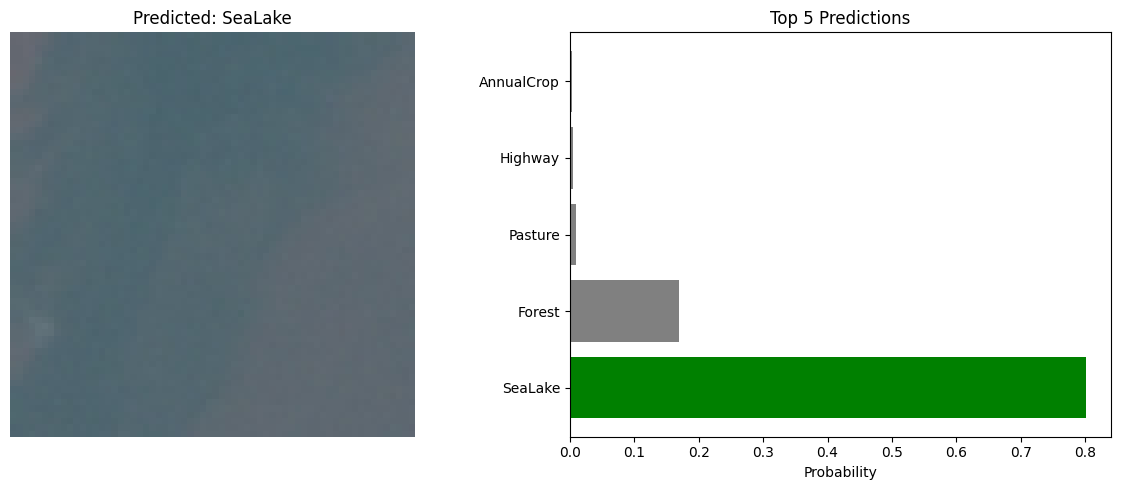

Visualizing prediction for: AnnualCrop_2305.jpg


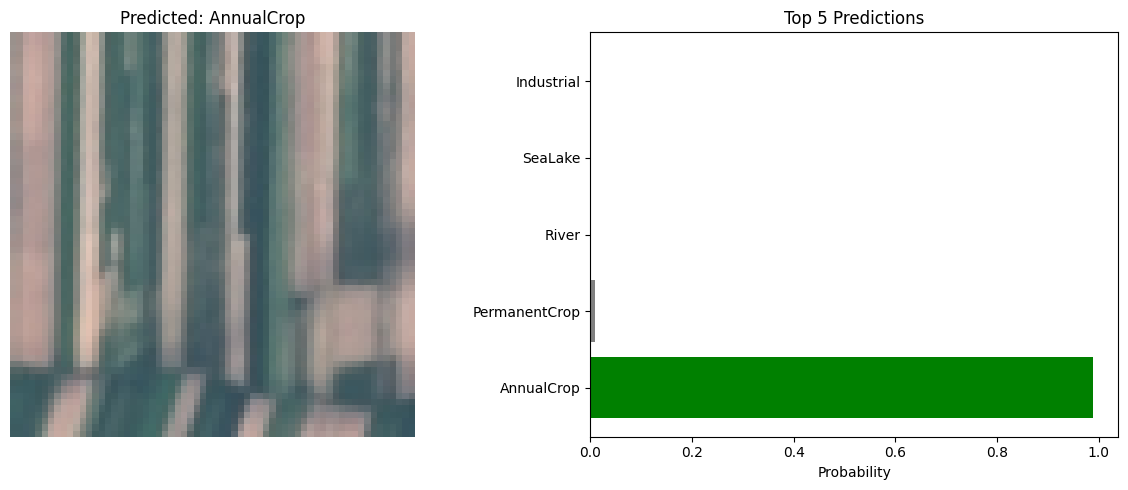

Visualizing prediction for: PermanentCrop_1096.jpg


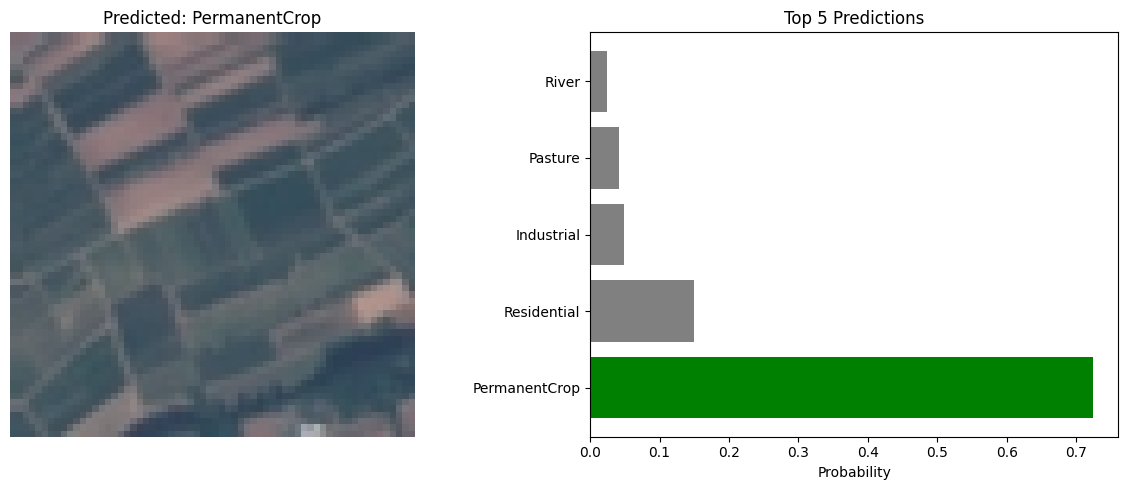

In [17]:
# Visualize predictions for random images
print("\n--- Standard Predictions ---")
for image_path in random_images:
    print(f"Visualizing prediction for: {os.path.basename(image_path)}")
    visualize_prediction(image_path, model, transform)

In [19]:
# =============================================
# GradCAM Visualization Section - Using a separate model instance to avoid hook conflicts
# =============================================

In [ ]:
print("\n--- Class Activation Map (GradCAM) Visualization ---")
print("Creating a separate model instance for GradCAM to avoid hook conflicts...")

# Create a SEPARATE copy of the model just for GradCAM
gradcam_model = None
if model_name == 'resnet18':
    gradcam_model = models.resnet18(weights=None)
    num_ftrs = gradcam_model.fc.in_features
    gradcam_model.fc = nn.Linear(num_ftrs, len(class_to_idx))
elif model_name == 'resnet50':
    gradcam_model = models.resnet50(weights=None)
    num_ftrs = gradcam_model.fc.in_features
    gradcam_model.fc = nn.Linear(num_ftrs, len(class_to_idx))
elif model_name == 'efficientnet_b0':
    gradcam_model = models.efficientnet_b0(weights=None)
    num_ftrs = gradcam_model.classifier[1].in_features
    gradcam_model.classifier[1] = nn.Linear(num_ftrs, len(class_to_idx))
elif model_name == 'efficientnet_b4':
    gradcam_model = models.efficientnet_b4(weights=None)
    num_ftrs = gradcam_model.classifier[1].in_features
    gradcam_model.classifier[1] = nn.Linear(num_ftrs, len(class_to_idx))


--- Class Activation Map (GradCAM) Visualization ---
Creating a separate model instance for GradCAM to avoid hook conflicts...


In [27]:
# Load weights into the separate model
gradcam_model.load_state_dict(checkpoint['model_state_dict'])
gradcam_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [28]:
# Ensure gradients are enabled for gradcam_model (required for GradCAM)
for param in gradcam_model.parameters():
    param.requires_grad = True

In [40]:
def visualize_gradcam(image_path, model, transform):
    """
    Visualize Class Activation Maps (GradCAM) for an image
    """
    # Load image
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0)
    
    # Determine which layer to use based on model architecture
    if model_name.startswith('resnet'):
        target_layer = model.layer4[-1]
    elif model_name.startswith('efficientnet'):
        target_layer = model.features[-1]
    
    # Initialize GradCAM with the model and target layer
    gradcam = GradCAM(model, target_layer)
    
    try:
        # Get model prediction
        output = model(input_tensor)
        predicted_class = torch.argmax(output, dim=1).item()
        
        # Get activation map
        activation_map = gradcam(
            class_idx=[predicted_class],
            scores=output
        )
        
        # Debug the shape of activation_map
        print(f"Activation map shape: {activation_map[0].shape}")
        
        # Extract and reshape properly - ensure it's a 2D array
        cam = activation_map[0].cpu().numpy()
        
        # If cam has more than 2 dimensions, take the first one
        if cam.ndim > 2:
            cam = cam.squeeze()  # Remove dimensions of size 1
        
        # If still not 2D, take first channel or average
        if cam.ndim > 2:
            cam = cam[0]  # Take first channel
            # Alternative: cam = np.mean(cam, axis=0)  # Average all channels
            
        print(f"Processed CAM shape: {cam.shape}")
        
        # Resize CAM to match input image size for better visualization
        from PIL import Image as PILImage
        import matplotlib.cm as cm
        
        # Create figure for visualization
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        # Original image
        axes[0].imshow(image)
        axes[0].set_title('Original Image')
        axes[0].axis('off')
        
        # Activation map (heatmap)
        axes[1].imshow(cam, cmap='jet')
        axes[1].set_title('Class Activation Map')
        axes[1].axis('off')
        
        # Resize cam to image size for overlay
        cam_resized = np.array(PILImage.fromarray(cam).resize((image.width, image.height), PILImage.BICUBIC))
        
        # Normalize if needed
        if cam_resized.max() > 0:
            cam_resized = cam_resized / cam_resized.max()
        
        # Apply colormap
        heatmap = cm.jet(cam_resized)[:, :, :3]  # Get RGB part
        
        # Create overlay
        overlay = 0.7 * np.array(image) / 255.0 + 0.3 * heatmap
        overlay = np.clip(overlay * 255, 0, 255).astype(np.uint8)
        
        # Display overlay
        axes[2].imshow(overlay)
        axes[2].set_title(f'Overlay: {idx_to_class[predicted_class]}')
        axes[2].axis('off')
        
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error during GradCAM visualization: {e}")
        import traceback
        traceback.print_exc()
    finally:
        # Clean up by removing hooks to avoid conflicts
        gradcam.remove_hooks()

Visualizing GradCAM for: SeaLake_1242.jpg
Activation map shape: torch.Size([1, 2, 2])
Processed CAM shape: (2, 2)


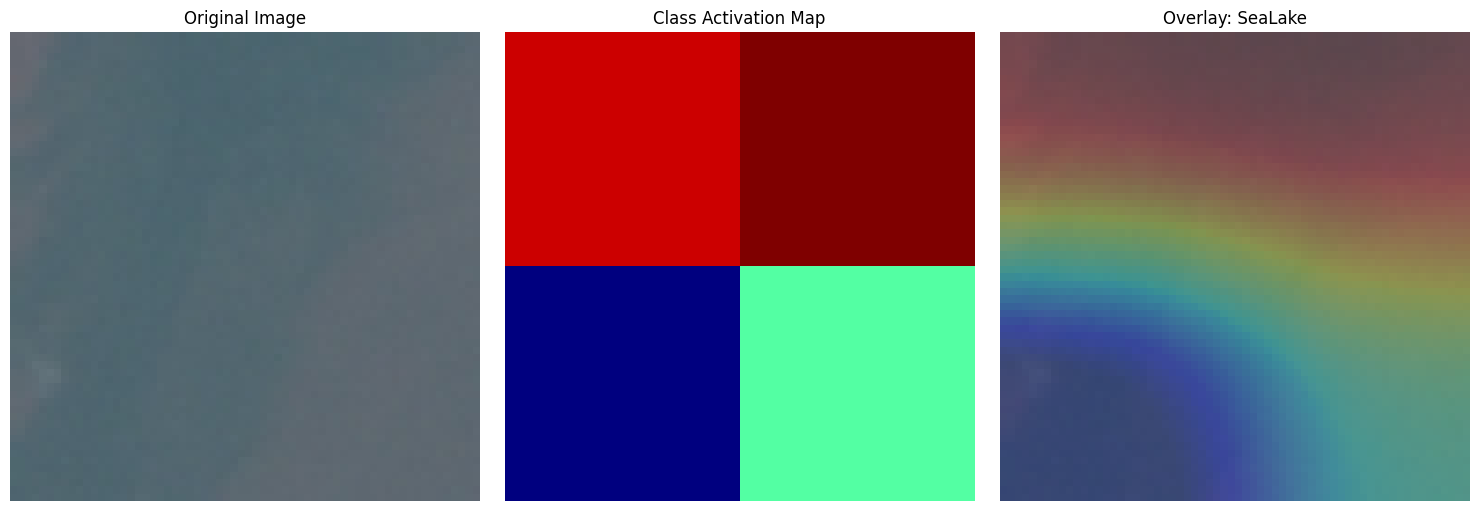

Visualizing GradCAM for: AnnualCrop_2305.jpg
Activation map shape: torch.Size([1, 2, 2])
Processed CAM shape: (2, 2)


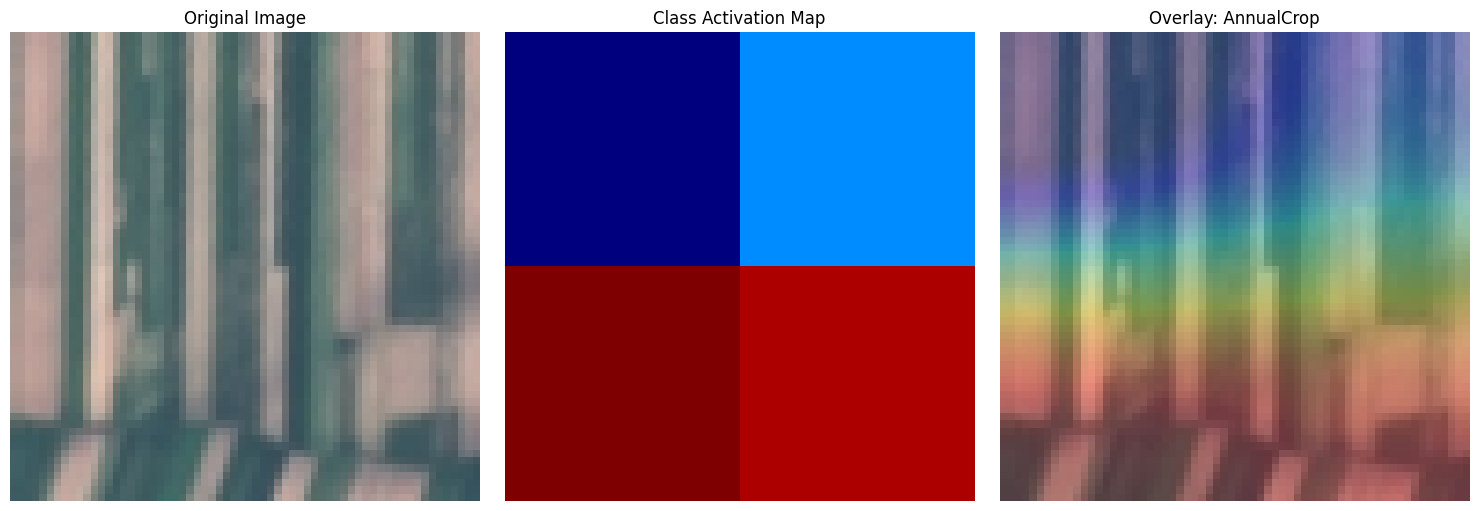

Visualizing GradCAM for: PermanentCrop_1096.jpg
Activation map shape: torch.Size([1, 2, 2])
Processed CAM shape: (2, 2)


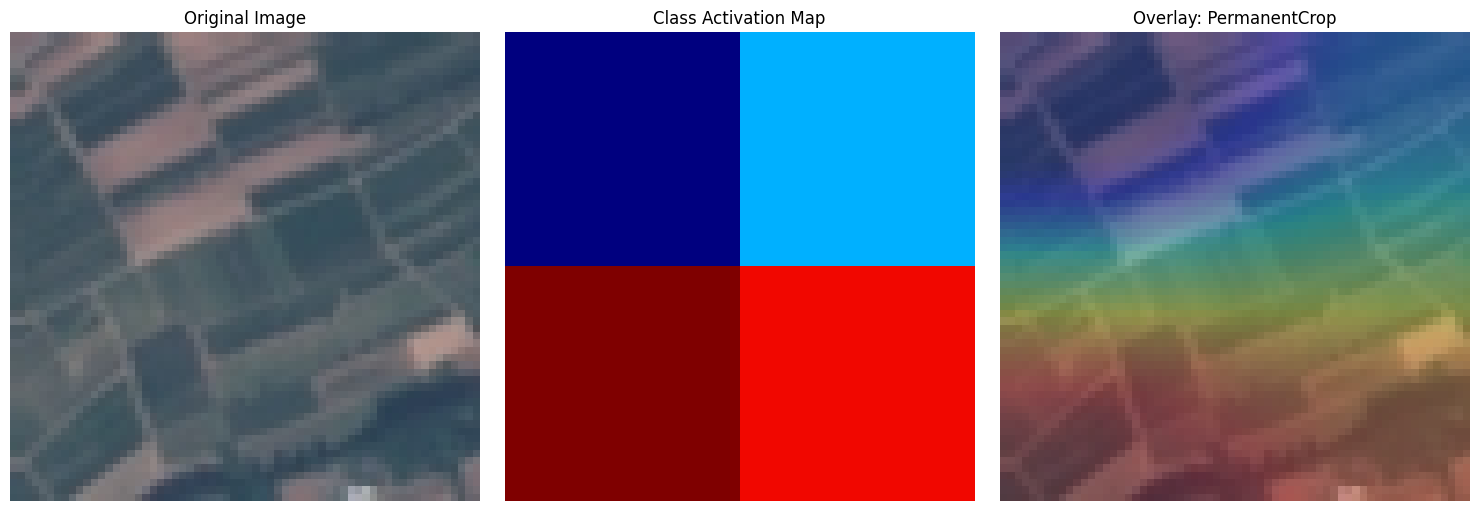

In [41]:
# Visualize GradCAM for the random images using the dedicated model
for image_path in random_images:
    print(f"Visualizing GradCAM for: {os.path.basename(image_path)}")
    visualize_gradcam(image_path, gradcam_model, transform)

In [42]:
# =============================================
# Misclassification Analysis
# =============================================

In [43]:
def analyze_misclassifications(model, transform, num_samples=5):
    """
    Find and visualize misclassified examples
    
    Args:
        model: PyTorch model for inference
        transform: Preprocessing transformations
        num_samples: Maximum number of misclassifications to find
    """
    print(f"\n--- Misclassification Analysis ---")
    print(f"Searching for up to {num_samples} misclassifications...")
    
    misclassified_images = []
    
    # Iterate through classes
    for class_name in sorted(os.listdir(DATASET_DIR)):
        class_path = os.path.join(DATASET_DIR, class_name)
        true_class_idx = class_to_idx[class_name]
        
        # Only look at a random subset of images for efficiency
        image_files = [f for f in os.listdir(class_path) if f.endswith('.jpg')]
        for image_file in random.sample(image_files, min(50, len(image_files))):
            image_path = os.path.join(class_path, image_file)
            
            # Predict
            pred_class, _, _ = predict_image(image_path, model, transform)
            
            # If misclassified
            if pred_class != true_class_idx:
                misclassified_images.append((image_path, true_class_idx, pred_class))
                
                # Break after finding enough misclassifications
                if len(misclassified_images) >= num_samples:
                    break
        
        if len(misclassified_images) >= num_samples:
            break
    
    # Visualize misclassifications
    if misclassified_images:
        print(f"Found {len(misclassified_images)} misclassifications")
        fig, axes = plt.subplots(2, 3, figsize=(15, 10)) if num_samples >= 6 else plt.subplots(1, len(misclassified_images), figsize=(5*len(misclassified_images), 5))
        axes = axes.flatten() if num_samples >= 2 else [axes]
        
        for i, (img_path, true_class, pred_class) in enumerate(misclassified_images[:num_samples]):
            img = Image.open(img_path).convert('RGB')
            axes[i].imshow(img)
            axes[i].set_title(f"True: {idx_to_class[true_class]}\nPred: {idx_to_class[pred_class]}")
            axes[i].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # For deeper analysis of a misclassified example, show GradCAM
        if misclassified_images:
            print("\nGradCAM analysis of a misclassified example:")
            visualize_gradcam(misclassified_images[0][0], gradcam_model, transform)
    else:
        print("No misclassifications found in the samples analyzed.")


--- Misclassification Analysis ---
Searching for up to 5 misclassifications...
Found 5 misclassifications


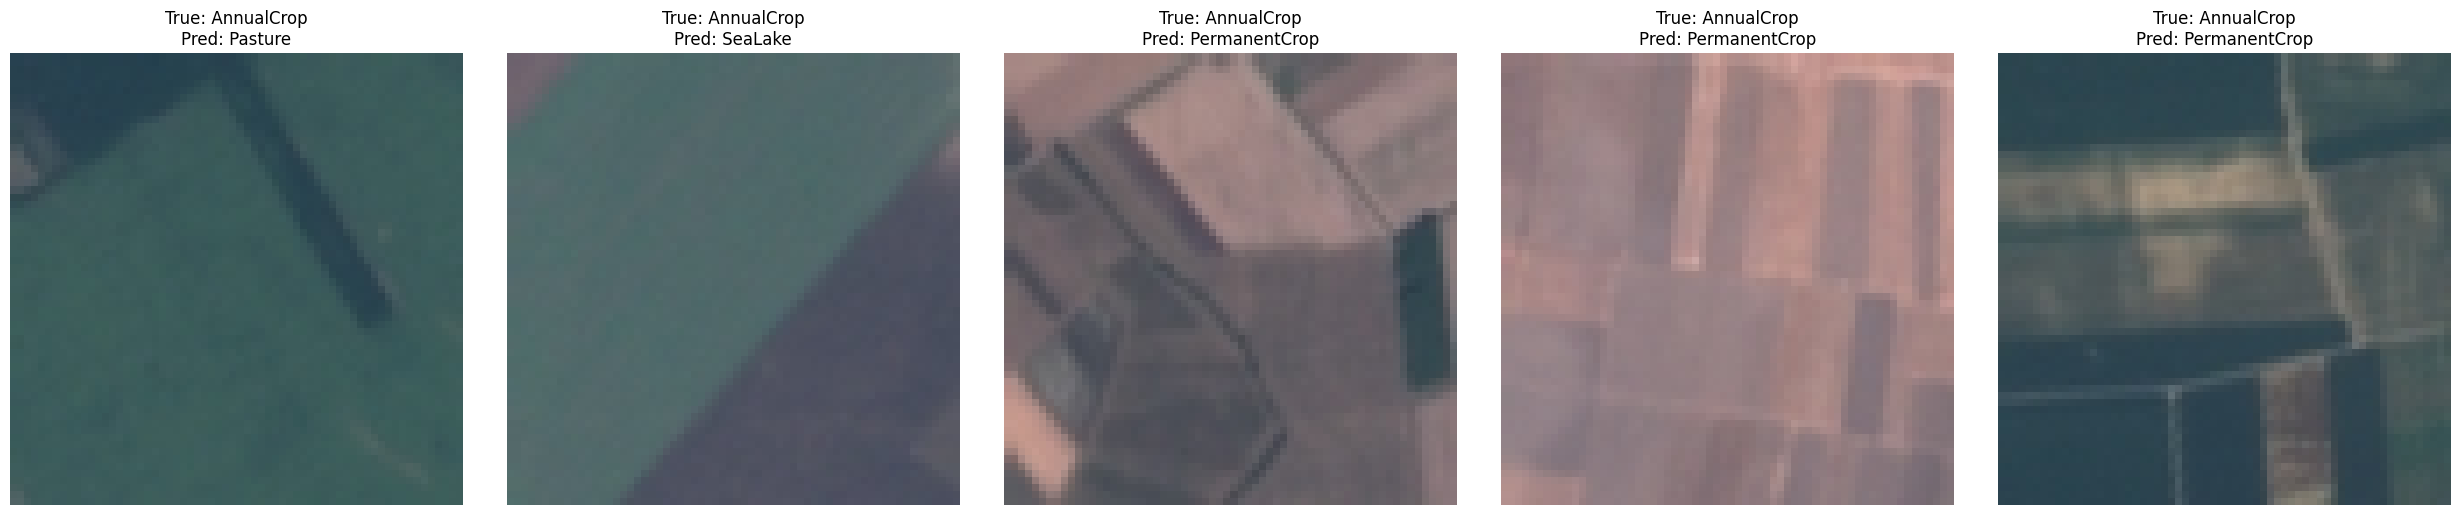


GradCAM analysis of a misclassified example:
Activation map shape: torch.Size([1, 2, 2])
Processed CAM shape: (2, 2)


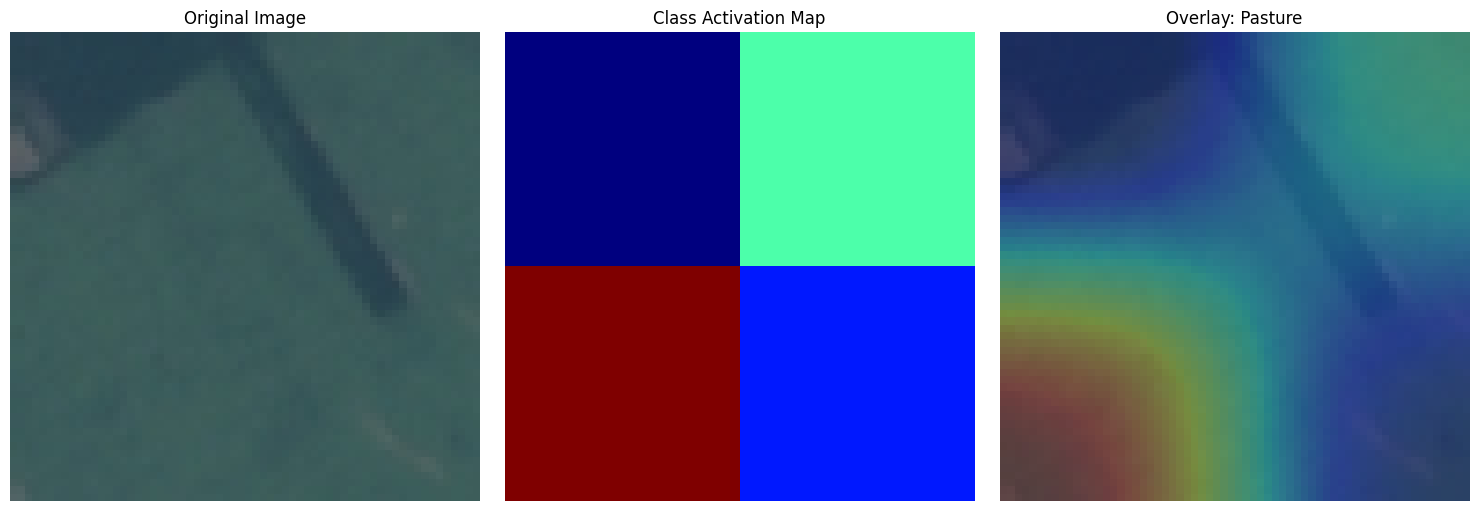


Evaluation and visualization complete!


In [ ]:
# Run misclassification analysis
analyze_misclassifications(model, transform)
print("\nEvaluation and visualization complete!")